<a href="https://colab.research.google.com/github/alexlehner3868/TrojanDetectionInNeuralNetworks/blob/main/TrojanDetection_imageclassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**bold text**# Set Up

In [1]:
# Imports
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
from torch.utils.data import Subset
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random

In [2]:
#!pip install --upgrade pip
#!pip install --no-cache-dir pandas scikit-learn


# Import and Process Data Helper Funtions

In [3]:
# Calculate the mean and standard deviation per-channel
def compute_mean_std(dataset, batch_size=512):
  # Create DataLoader
  loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

  mean = torch.zeros(3)
  std = torch.zeros(3)
  num_pixels = 0

  # Loop over batches (x = batch of images)
  for x, _ in loader:
    # Unpack dimension: (Batch size, num channels=3, width=32, height=32)
    num_samples_in_batch, _, height, width = x.shape
    # Count number of pixels
    num_pixels += num_samples_in_batch * height * width
    # Sum over each channel (compute the numerators for mean and std)
    mean += x.sum(dim=(0, 2, 3))
    std += (x ** 2).sum(dim=(0, 2, 3))

  # Compute the mean and standard deviations
  mean /= num_pixels
  std = torch.sqrt(std / num_pixels - mean ** 2)

  return mean.tolist(), std.tolist()

# Function to load and split the dataset
def load_and_split_cifar10(data_root="./data", val_split=0.16, seed=42):

  base_transform = transforms.ToTensor()

  # Load the training dataset (without normalization)
  train_full_original = datasets.CIFAR10(root=data_root, train=True, download=True, transform=base_transform)

  # Calculate the mean and standard deviation on the training set
  mean, std = compute_mean_std(train_full_original)

  # Construct the transform with normalization
  final_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])

  # Load datasets with normalization
  train_full = datasets.CIFAR10(root=data_root,train=True, download=False, transform=final_transform)
  test_set = datasets.CIFAR10(root=data_root, train=False,download=True,transform=final_transform)

  # Create validation set from the training dataset
  val_size = int(len(train_full) * val_split)
  train_size = len(train_full) - val_size
  g = torch.Generator().manual_seed(seed)
  train_set, val_set = random_split(train_full, [train_size, val_size], generator=g)

  return train_set, val_set, test_set, mean, std


In [4]:
# Function to process the data and generate the data loaders
def process_data(batch_size=128, val_split=0.16,poison=False, plot_distribution=True):
  # Load dataset and create splits
  train_set, val_set, test_set, mean, std = load_and_split_cifar10(val_split=val_split)

  if plot_distribution:
    plot_class_distribution(train_set, "Training set")
    plot_class_distribution(val_set, "Validation set")
    plot_class_distribution(test_set, "Test set")

  if poison:
      print("CALL FUNCTION TO POISON THE DATA")
      if plot_distribution:
        plot_class_distribution(train_set, "Training set - Poisoned")
        plot_class_distribution(val_set, "Validation set - Poisoned")
        plot_class_distribution(test_set, "Test set -  Poisoned")


  # Create DataLoaders from datasets
  train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
  val_loader   = DataLoader(val_set,   batch_size=batch_size, shuffle=False)
  test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False)

  print(f"Computed normalization stats:")
  print(f"Mean: {mean}")
  print(f"Std:  {std}")

  return train_loader, val_loader, test_loader

# Graphing Helper Functions

In [5]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Subset

CIFAR10_CLASSES = ("airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

def plot_class_distribution(dataset, title):
    # Get labels
    if isinstance(dataset, Subset):
        labels = [dataset.dataset.targets[i] for i in dataset.indices]
    else:
        labels = dataset.targets

    # Get counts per category
    counts = torch.bincount(torch.tensor(labels), minlength=len(CIFAR10_CLASSES))

    plt.figure(figsize=(10, 4))
    plt.bar(CIFAR10_CLASSES, counts)
    plt.ylabel("Number of samples")
    plt.title(title)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


100%|██████████| 170M/170M [00:06<00:00, 28.4MB/s]


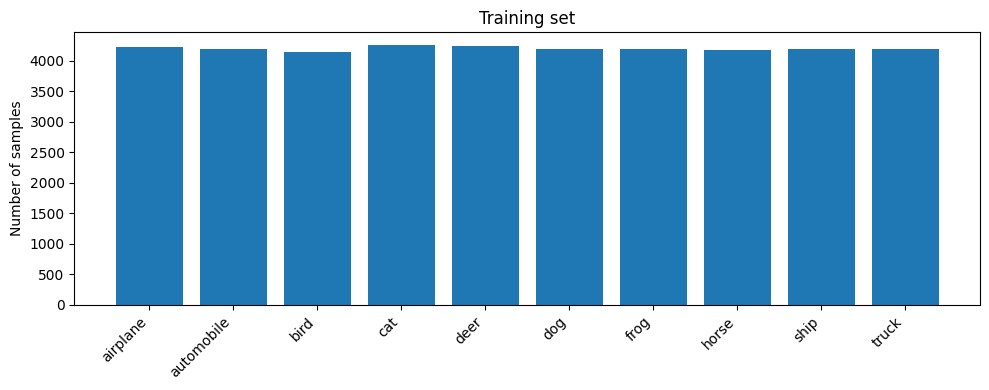

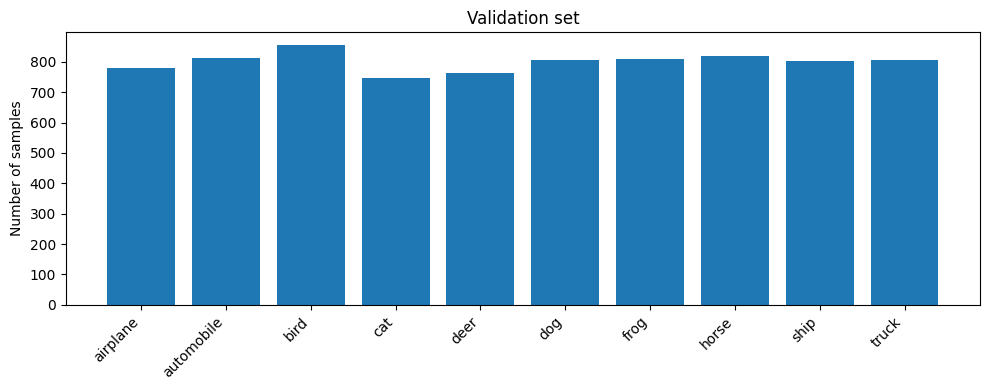

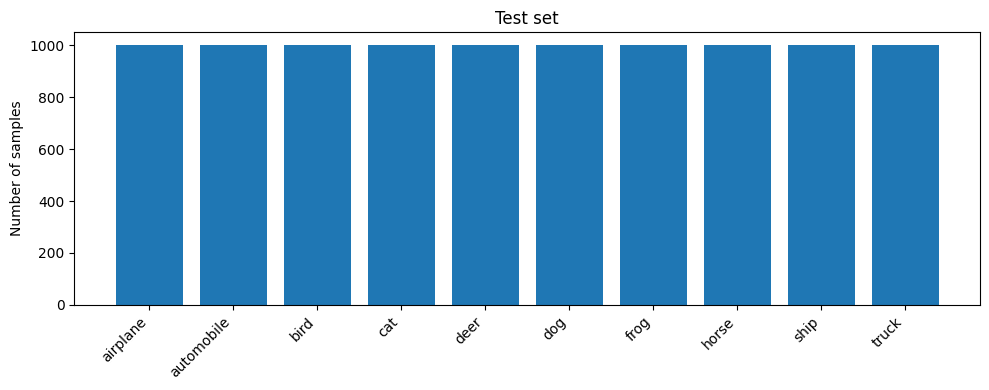

Computed normalization stats:
Mean: [0.4913996756076813, 0.48215851187705994, 0.4465310275554657]
Std:  [0.24703219532966614, 0.24348489940166473, 0.2615877091884613]


In [6]:
# Get dataloader for each dataset
train_loader, val_loader, test_loader = process_data()

In [7]:
class CNN_image_classifier(nn.Module):
  def __init__(self, num_classes=2, num_detectors=32):
      super(CNN_image_classifier, self).__init__()
      # First block of layers
      self.layer1 = nn.Sequential(
          nn.Conv2d(3, num_detectors, kernel_size=3, padding=1),  # input channels = 3 (RGB), input size -> 32 neurons, padding to reduce too much shrinkage
          nn.ReLU(),# activation
          nn.BatchNorm2d(num_detectors),# standardize after the forward pass
          nn.Conv2d(num_detectors, num_detectors, kernel_size=3, padding=1), # Conv layer 32 -> 32
          nn.ReLU(),
          nn.BatchNorm2d(num_detectors),
          nn.MaxPool2d(kernel_size=2, stride=2), # Reduce the spatial dimenstions of the higher spatial map, reduces training time by averaging across a kernal of 2 and stride two
          nn.Dropout(0.2)
      )

      # Second block of layers
      self.layer2 = nn.Sequential(
          nn.Conv2d(num_detectors, 2*num_detectors, kernel_size=3, padding=1), #, 32 -> 64 neurons, padding to reduce too much shrinkage
          nn.ReLU(),
          nn.BatchNorm2d(2*num_detectors),
          nn.Conv2d(2*num_detectors, 2*num_detectors, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(2*num_detectors),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Dropout(0.2) # randomly dropes nodes in the neural network tp avoid overfitting
      )

      # Third block of layers
      self.layer3 = nn.Sequential(
          nn.Conv2d(2*num_detectors, 4*num_detectors, kernel_size=3, padding=1),# 64 -> 128 neurons, padding to reduce too much shrinkage
          nn.ReLU(),
          nn.BatchNorm2d(4*num_detectors),
          nn.Conv2d(4*num_detectors, 4*num_detectors, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(4*num_detectors),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Dropout(0.2)
      )

      # Fourth block of layers
      self.layer4 = nn.Sequential(
          nn.Conv2d(4*num_detectors, 8*num_detectors, kernel_size=3, padding=1), # 128 -> 256 neurons, padding to reduce too much shrinkage
          nn.ReLU(),
          nn.BatchNorm2d(8*num_detectors),
          nn.Conv2d(8*num_detectors, 8*num_detectors, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(8*num_detectors),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Dropout(0.2)
      )

      # Flatten layer
      self.flatten = nn.Flatten()
      final_conv_output_size = 1024
      self.fc1 = nn.Sequential(
          nn.Linear(final_conv_output_size, 2 * num_detectors),  # Adjust the input features based on your image size
          nn.ReLU(),
          nn.BatchNorm1d(2 * num_detectors),
          nn.Dropout(0.2)
      )

      self.fc2 = nn.Sequential(
          nn.Linear(2 * num_detectors, 2 * num_detectors),
          nn.ReLU(),
          nn.BatchNorm1d(2 * num_detectors),
          nn.Dropout(0.2)
      )

      self.fc3 = nn.Linear(2 * num_detectors, num_classes)

  def forward(self, x):
      x = self.layer1(x)
      x = self.layer2(x)
      x = self.layer3(x)
      x = self.layer4(x)

      x = self.flatten(x)
      x = self.fc1(x)
      x = self.fc2(x)
      x = self.fc3(x)
      return x

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.long().to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}] Loss: {loss.item():.6f}')

# Test function
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.long().to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    accuracy = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds, average='weighted')
    recall = recall_score(all_targets, all_preds, average='weighted')
    f1 = f1_score(all_targets, all_preds, average='weighted')

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}\n')
    print('Classification Report:')
    print(classification_report(all_targets, all_preds))

    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy, precision, recall, f1, all_targets, all_preds

Using device: cuda


In [13]:
model = CNN_image_classifier(num_classes=10, num_detectors=32).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

for epoch in range(50):  # Adjust number of epochs as needed

    train(model, device, train_loader, optimizer, criterion, epoch)

Train Epoch: 0 [0/42000] Loss: 2.504997
Train Epoch: 0 [12800/42000] Loss: 1.907411
Train Epoch: 0 [25600/42000] Loss: 1.685456
Train Epoch: 0 [38400/42000] Loss: 1.713658
Train Epoch: 1 [0/42000] Loss: 1.638123
Train Epoch: 1 [12800/42000] Loss: 1.455480
Train Epoch: 1 [25600/42000] Loss: 1.385343
Train Epoch: 1 [38400/42000] Loss: 1.402408
Train Epoch: 2 [0/42000] Loss: 1.492808
Train Epoch: 2 [12800/42000] Loss: 1.231442
Train Epoch: 2 [25600/42000] Loss: 1.310826
Train Epoch: 2 [38400/42000] Loss: 1.314059
Train Epoch: 3 [0/42000] Loss: 1.318323
Train Epoch: 3 [12800/42000] Loss: 1.191525
Train Epoch: 3 [25600/42000] Loss: 1.173513
Train Epoch: 3 [38400/42000] Loss: 1.017862
Train Epoch: 4 [0/42000] Loss: 1.035984
Train Epoch: 4 [12800/42000] Loss: 1.091506
Train Epoch: 4 [25600/42000] Loss: 1.197690
Train Epoch: 4 [38400/42000] Loss: 1.275460
Train Epoch: 5 [0/42000] Loss: 0.894804
Train Epoch: 5 [12800/42000] Loss: 1.030891
Train Epoch: 5 [25600/42000] Loss: 1.042831
Train Epoch:

Final evaluation on test set:

Test set: Average loss: 0.0056, Accuracy: 0.8303, Precision: 0.8297, Recall: 0.8303, F1-Score: 0.8293

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85       779
           1       0.92      0.93      0.92       812
           2       0.81      0.75      0.78       854
           3       0.67      0.64      0.66       748
           4       0.76      0.84      0.80       764
           5       0.75      0.72      0.73       807
           6       0.85      0.90      0.87       810
           7       0.85      0.86      0.85       818
           8       0.89      0.93      0.91       803
           9       0.90      0.89      0.90       805

    accuracy                           0.83      8000
   macro avg       0.83      0.83      0.83      8000
weighted avg       0.83      0.83      0.83      8000



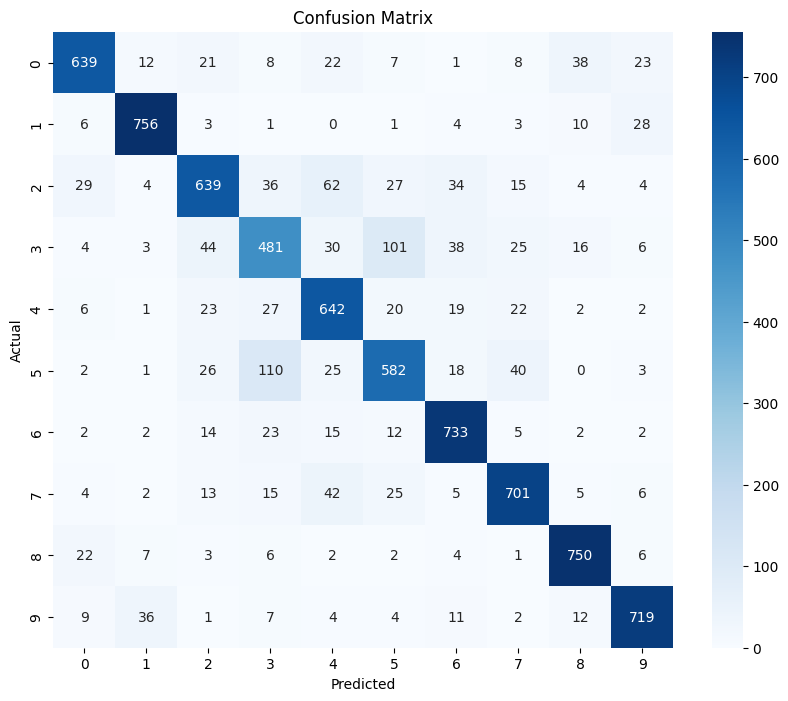

In [14]:
final_model_test = model
model.eval()  # Set the model to evaluation mode
final_optimizer = optim.Adam(final_model_test.parameters(), lr=0.0001)
final_criterion = nn.CrossEntropyLoss()



# Evaluate the final model on the test set
print("Final evaluation on test set:")
final_accuracy, final_precision, final_recall, final_f1, _, _ = test(final_model_test, device, val_loader, final_criterion)